In [1]:
import pyreadr
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import scipy.cluster.hierarchy as sch

from dredFISH.Utils.__init__plots import *

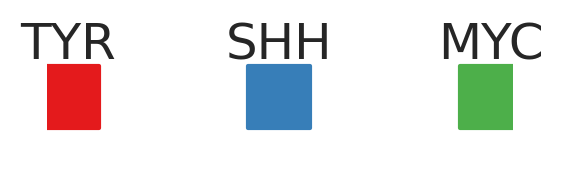

In [2]:
colors = sns.color_palette('Set1', 3)
palette = {
    'TYR': colors[0],
    'SHH': colors[1],
    'MYC': colors[2],
}

fig, ax = plt.subplots(figsize=(3,1))
for i, (t, c) in enumerate(palette.items()):
    ax.text(i+0.5, 0.02, t, ha='center', va='bottom')
    ax.scatter([i+0.5], [0], color=c, marker='s', s=500)
ax.axis('off')
plt.show()

# organize Johann et al

In [3]:
f = "./data/Johann_2016/Johann_2016_betas_annotated.h5ad"
adata = anndata.read(f)
print(adata.shape)

# select autosomes only
cond0 = ~adata.obs['CHR'].str.contains("[X,Y,N,A]")
adata = adata[cond0]
print(adata.shape)

# adata
adata, adata.obs['CHR'].unique()

(485512, 150)
(473864, 150)


(View of AnnData object with n_obs × n_vars = 473864 × 150
     obs: 'Name', 'AddressA_ID', 'AlleleA_ProbeSeq', 'AddressB_ID', 'AlleleB_ProbeSeq', 'Infinium_Design_Type', 'Next_Base', 'Color_Channel', 'Forward_Sequence', 'Genome_Build', 'CHR', 'MAPINFO', 'SourceSeq', 'Chromosome_36', 'Coordinate_36', 'Strand', 'Probe_SNPs', 'Probe_SNPs_10', 'Random_Loci', 'Methyl27_Loci', 'UCSC_RefGene_Name', 'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'UCSC_CpG_Islands_Name', 'Relation_to_UCSC_CpG_Island', 'Phantom', 'DMR', 'Enhancer', 'HMM_Island', 'Regulatory_Feature_Name', 'Regulatory_Feature_Group', 'DHS'
     var: 'Molecular Subgroup (Consensus)', 'Subgrouping based on 450K methylation data', 'Subrouping based on Affymetrix gene expression data', 'Subgrouping based on WGBS methylation data', 'Subgrouping based on H3K27Ac enhancer correlation', 'WGS cohort', 'RNASequencing cohort', 'WGBS cohort', 'H3K27Ac ChIP Sequencing cohort', 'BRD4 ChIP Sequencing cohort', 'OTX2 ChIP Sequencing cohort', 'M

In [4]:
meta_order = adata.var.sort_values('Subgrouping based on 450K methylation data')
samp_order = meta_order.index.values
clsts_order = meta_order['Subgrouping based on 450K methylation data'].values
hps = adata.obs.index.values
hps

array(['cg00000957', 'cg00001349', 'cg00001583', ..., 'ch.22.1008279F',
       'ch.22.47579720R', 'ch.22.48274842R'], dtype=object)

# organize our data

In [5]:
f = "all_probes_sesame_normalized_annotated.h5ad"
adata_m = anndata.read(f)
print(adata_m.shape)

# select autosomes only
cond0 = adata_m.obs['CHR'].str.contains('[1-9]') 
adata_m = adata_m[cond0]
print(adata_m.shape)

# select unique probes only
adata_m = adata_m[adata_m.obs['havingReplicates']=='no']
print(adata_m.shape)

# use CGid as the probe names
# adata_m.obs.index = adata_m.obs['CGid'].astype(str).values #('CGid') # this direct changes are buggy
assert len(adata_m.obs['CGid'].unique()) == len(adata_m)
adata_m = anndata.AnnData(adata_m.X,
                          var=adata_m.var,
                          obs=adata_m.obs.set_index('CGid'),
                         )

adata_m

(326732, 12)
(298030, 12)
(291777, 12)


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 291777 × 12
    obs: 'mammalianArrayProbes', 'mammalianProbesToUse.rmCor0.7Plus.ResMouseLessThan0.25.Calibration0.8Plus', 'havingReplicates', 'mapUniqWanding', 'SYMBOL', 'GeneRegionID', 'seqnames', 'probeStart', 'probeEnd', 'CGstart', 'CGend', 'width', 'strand', 'seq', 'annotation', 'geneChr', 'geneStart', 'geneEnd', 'geneLength', 'geneStrand', 'transcriptId', 'distanceToTSS', 'flank_txIds', 'flank_geneIds', 'flank_gene_distances', 'genic', 'Intergenic', 'Promoter', 'fiveUTR', 'threeUTR', 'Exon', 'Intron', 'downstream', 'distal_intergenic', 'main_Categories', 'CpG_number_on_geneRegion', 'CpGs_number_on_gene', 'ENTREZID', 'ENSEMBL', 'conservationInHuman', 'CGIslandNess', 'CG', 'stackHMM', 'stackHMM.Rob', 'repeatElements', 'GENENAME', 'CpGislandseqnames', 'CpGislandstart', 'CpGislandend', 'CpGislandwidth', 'CpGislandstrand', 'CpGislandlen', 'CpGislandcount', 'CpGislandgc', 'CpGislandoe', 'CpGislandden', 'CpGislandpvalue', 'CpGisland', 'Brown_rat.corCa

In [6]:
mps = adata_m.obs.index.values
ops = np.load('./data/m320k_i450k_overlap_5559.npy') # previous done -- including non-autosomes
cps = np.intersect1d(mps, hps)  # actual overlap
print(mps.shape, hps.shape, ops.shape, cps.shape)

(291777,) (473864,) (5559,) (2759,)


In [7]:
adata_m_comm = adata_m[cps]
df_m = adata_m_comm.to_df()
df_m

Basename,206535570066_R05C02,206535570066_R06C02,206535570010_R01C01,206535570010_R02C01,206535570010_R03C01,206535570010_R04C01,206535570010_R05C01,206535570010_R06C01,206535570010_R01C02,206535570010_R02C02,206535570010_R03C02,206535570010_R04C02
CGid,,,,,,,,,,,,
cg00001364,0.749347,0.914103,0.914649,0.516546,0.899112,0.916861,0.748892,0.912464,0.913994,0.920995,0.818239,0.859054
cg00001582,0.054638,0.054335,0.053501,0.081808,0.057557,0.062748,0.038457,0.051540,0.060898,0.036618,0.067346,0.061484
cg00003994,0.038456,0.030914,0.040603,0.039053,0.043289,0.042252,0.034478,0.025306,0.048871,0.034659,0.027721,0.035719
cg00005112,0.770640,0.651730,0.478689,0.821402,0.587515,0.760703,0.585092,0.736821,0.659390,0.258120,0.646213,0.493449
cg00010445,0.898236,0.865806,0.818651,0.857929,0.852993,0.688164,0.779249,0.848471,0.871075,0.880976,0.860716,0.841185
...,...,...,...,...,...,...,...,...,...,...,...,...
cg27656498,0.933701,0.950104,0.902517,0.919541,0.889101,0.915152,0.850191,0.935595,0.887838,0.916024,0.892301,0.928747
cg27656592,0.949432,0.944234,0.935360,0.946226,0.889323,0.922248,0.940710,0.917376,0.914249,0.939517,0.914805,0.937870
cg27659622,0.218862,0.362596,0.378165,0.271163,0.249348,0.307614,0.356541,0.291815,0.385474,0.318116,0.194879,0.205494


In [8]:
adata_h_comm = adata[cps]
df_h = adata_h_comm.to_df()

# order by sample clusters
df_h = df_h[samp_order] 
print(df_h.shape)

# remove nan (very few)
print(f"This many nan s to impute away: {np.isnan(df_h.values).sum()}")             # mean impute
print(f"samples: {np.isnan(df_h).sum(axis=0).sort_values(ascending=False).head()}") # mean impute
print(f"probes:  {np.isnan(df_h).sum(axis=1).sort_values(ascending=False).head()}") # mean impute
df_h = df_h.T.fillna(df_h.T.mean()).T # transpose and back -- pandas fillna only goes by columns
print(f"This many nan s to impute away: {np.isnan(df_h.values).sum()}")             # mean impute
print(df_h.shape)

# check mouse and human having the same probes (cps)
np.all(df_m.index.values == df_h.index.values)
df_h

(2759, 150)
This many nan s to impute away: 7
samples: dkfz_ATRT_122    2
dkfz_ATRT_63     1
dkfz_ATRT_105    1
dkfz_ATRT_125    1
dkfz_ATRT_33     1
dtype: int64
probes:  cg07451261    1
cg17347386    1
cg11942221    1
cg11946963    1
cg07412048    1
dtype: int64
This many nan s to impute away: 0
(2759, 150)


,dkfz_ATRT_69,dkfz_ATRT_120,dkfz_ATRT_89,dkfz_ATRT_90,dkfz_ATRT_20,dkfz_ATRT_27,dkfz_ATRT_50,dkfz_ATRT_116,dkfz_ATRT_53,dkfz_ATRT_49,...,dkfz_ATRT_100,dkfz_ATRT_101,dkfz_ATRT_102,dkfz_ATRT_40,dkfz_ATRT_34,dkfz_ATRT_111,dkfz_ATRT_113,dkfz_ATRT_30,dkfz_ATRT_48,dkfz_ATRT_33
cg00001364,0.768003,0.747809,0.711503,0.759919,0.619154,0.809465,0.679441,0.705206,0.707877,0.728284,...,0.578155,0.637130,0.649654,0.848573,0.824431,0.597185,0.717814,0.882880,0.645727,0.842411
cg00001582,0.064607,0.059014,0.057241,0.063941,0.048985,0.070318,0.054185,0.063944,0.046664,0.047276,...,0.069813,0.065609,0.044597,0.068779,0.053964,0.060097,0.055715,0.069498,0.043283,0.051766
cg00003994,0.159207,0.068092,0.257397,0.113081,0.071979,0.067977,0.073755,0.390746,0.049060,0.600963,...,0.100927,0.059107,0.106113,0.205376,0.063777,0.134254,0.048803,0.060877,0.062398,0.067517
cg00005112,0.370632,0.660018,0.653232,0.319040,0.628712,0.692114,0.498651,0.596512,0.613213,0.599526,...,0.600345,0.631446,0.599805,0.793165,0.747557,0.608734,0.656010,0.759870,0.560067,0.734479
cg00010445,0.361072,0.130539,0.284559,0.362561,0.195982,0.212269,0.282183,0.233234,0.118865,0.102931,...,0.209558,0.062365,0.403092,0.267834,0.158765,0.086524,0.271484,0.210080,0.119402,0.253723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg27656498,0.702272,0.847320,0.791120,0.788671,0.827659,0.864901,0.745787,0.794061,0.726563,0.786675,...,0.798936,0.798652,0.780805,0.863228,0.827090,0.824978,0.805835,0.836919,0.712952,0.817121
cg27656592,0.846074,0.860695,0.820563,0.751369,0.730144,0.772712,0.783497,0.695018,0.742574,0.755192,...,0.813853,0.849747,0.800511,0.833861,0.865569,0.831555,0.809139,0.882326,0.758932,0.866201
cg27659622,0.468139,0.647524,0.459524,0.331271,0.197687,0.147767,0.208272,0.295139,0.284416,0.380403,...,0.543420,0.702634,0.479550,0.599924,0.620190,0.454631,0.324651,0.497224,0.501777,0.554647
cg27661315,0.616595,0.854854,0.591532,0.135197,0.214336,0.194818,0.299401,0.426815,0.459565,0.619474,...,0.842772,0.829352,0.831032,0.728144,0.803061,0.801123,0.749192,0.681245,0.641552,0.808390


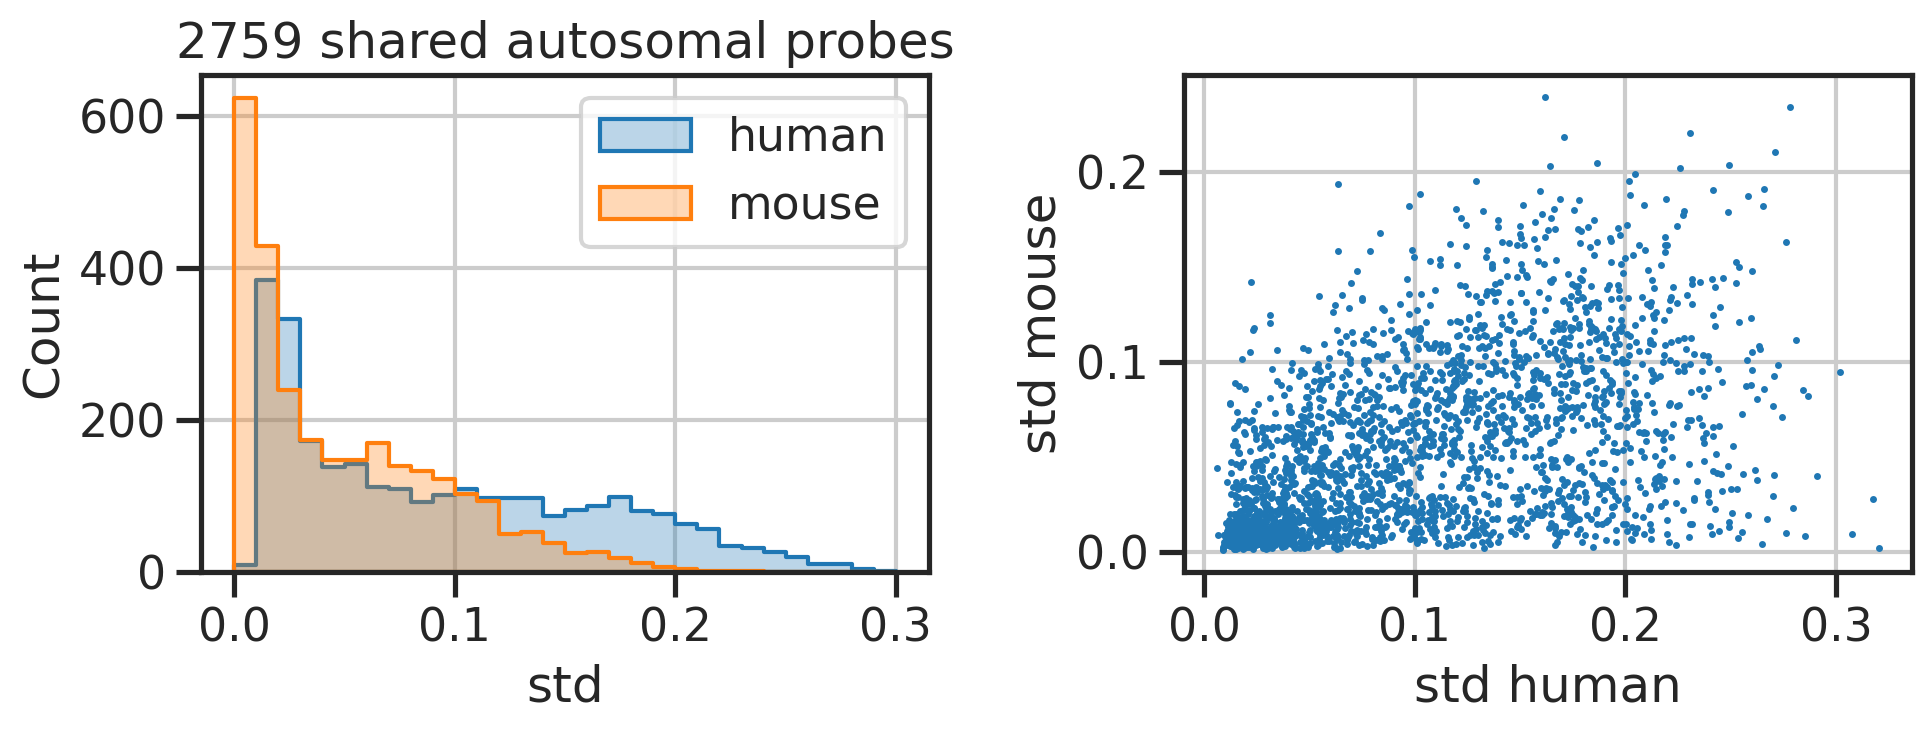

In [9]:

sites_std_h = df_h.std(axis=1, ddof=0)
sites_std_m = df_m.std(axis=1, ddof=0)

bins = np.arange(0,0.3+0.01,0.01)
fig, axs = plt.subplots(1,2,figsize=(2*5,1*4))
ax = axs[0]
sns.histplot(sites_std_h, bins=bins, ax=ax, element='step', color='C0', alpha=0.3, label='human')
sns.histplot(sites_std_m, bins=bins, ax=ax, element='step', color='C1', alpha=0.3, label='mouse')
ax.legend()
ax.set_xlabel('std')
ax.set_title(f"{len(sites_std_h)} shared autosomal probes") 
               
ax = axs[1]
ax.scatter(sites_std_h, sites_std_m, s=1)
ax.set_xlabel('std human')
ax.set_ylabel('std mouse')
fig.tight_layout()
plt.show()

In [10]:
th = 0.2
cond_h = sites_std_h > th
print(cond_h.sum())

th = 0.05
cond_m = sites_std_m > th
print(cond_m.sum())

cond = np.logical_and(cond_h, cond_m)
print(cond.sum())

df_h_hv = df_h[cond]
df_m_hv = df_m[cond]
print(df_h_hv.shape, df_m_hv.shape)

263
1147
180
(180, 150) (180, 12)


In [11]:
rl_h = sch.linkage(df_h_hv.values,   method='average')
rl_m = sch.linkage(df_m_hv.values,   method='average')

cl_h = sch.linkage(df_h_hv.values.T, method='average')
cl_m = sch.linkage(df_m_hv.values.T, method='average')

rord_h = np.array(sch.dendrogram(rl_h, no_plot=True)['leaves'])
rord_m = np.array(sch.dendrogram(rl_m, no_plot=True)['leaves'])
cord_m = np.array(sch.dendrogram(cl_m, no_plot=True)['leaves'])

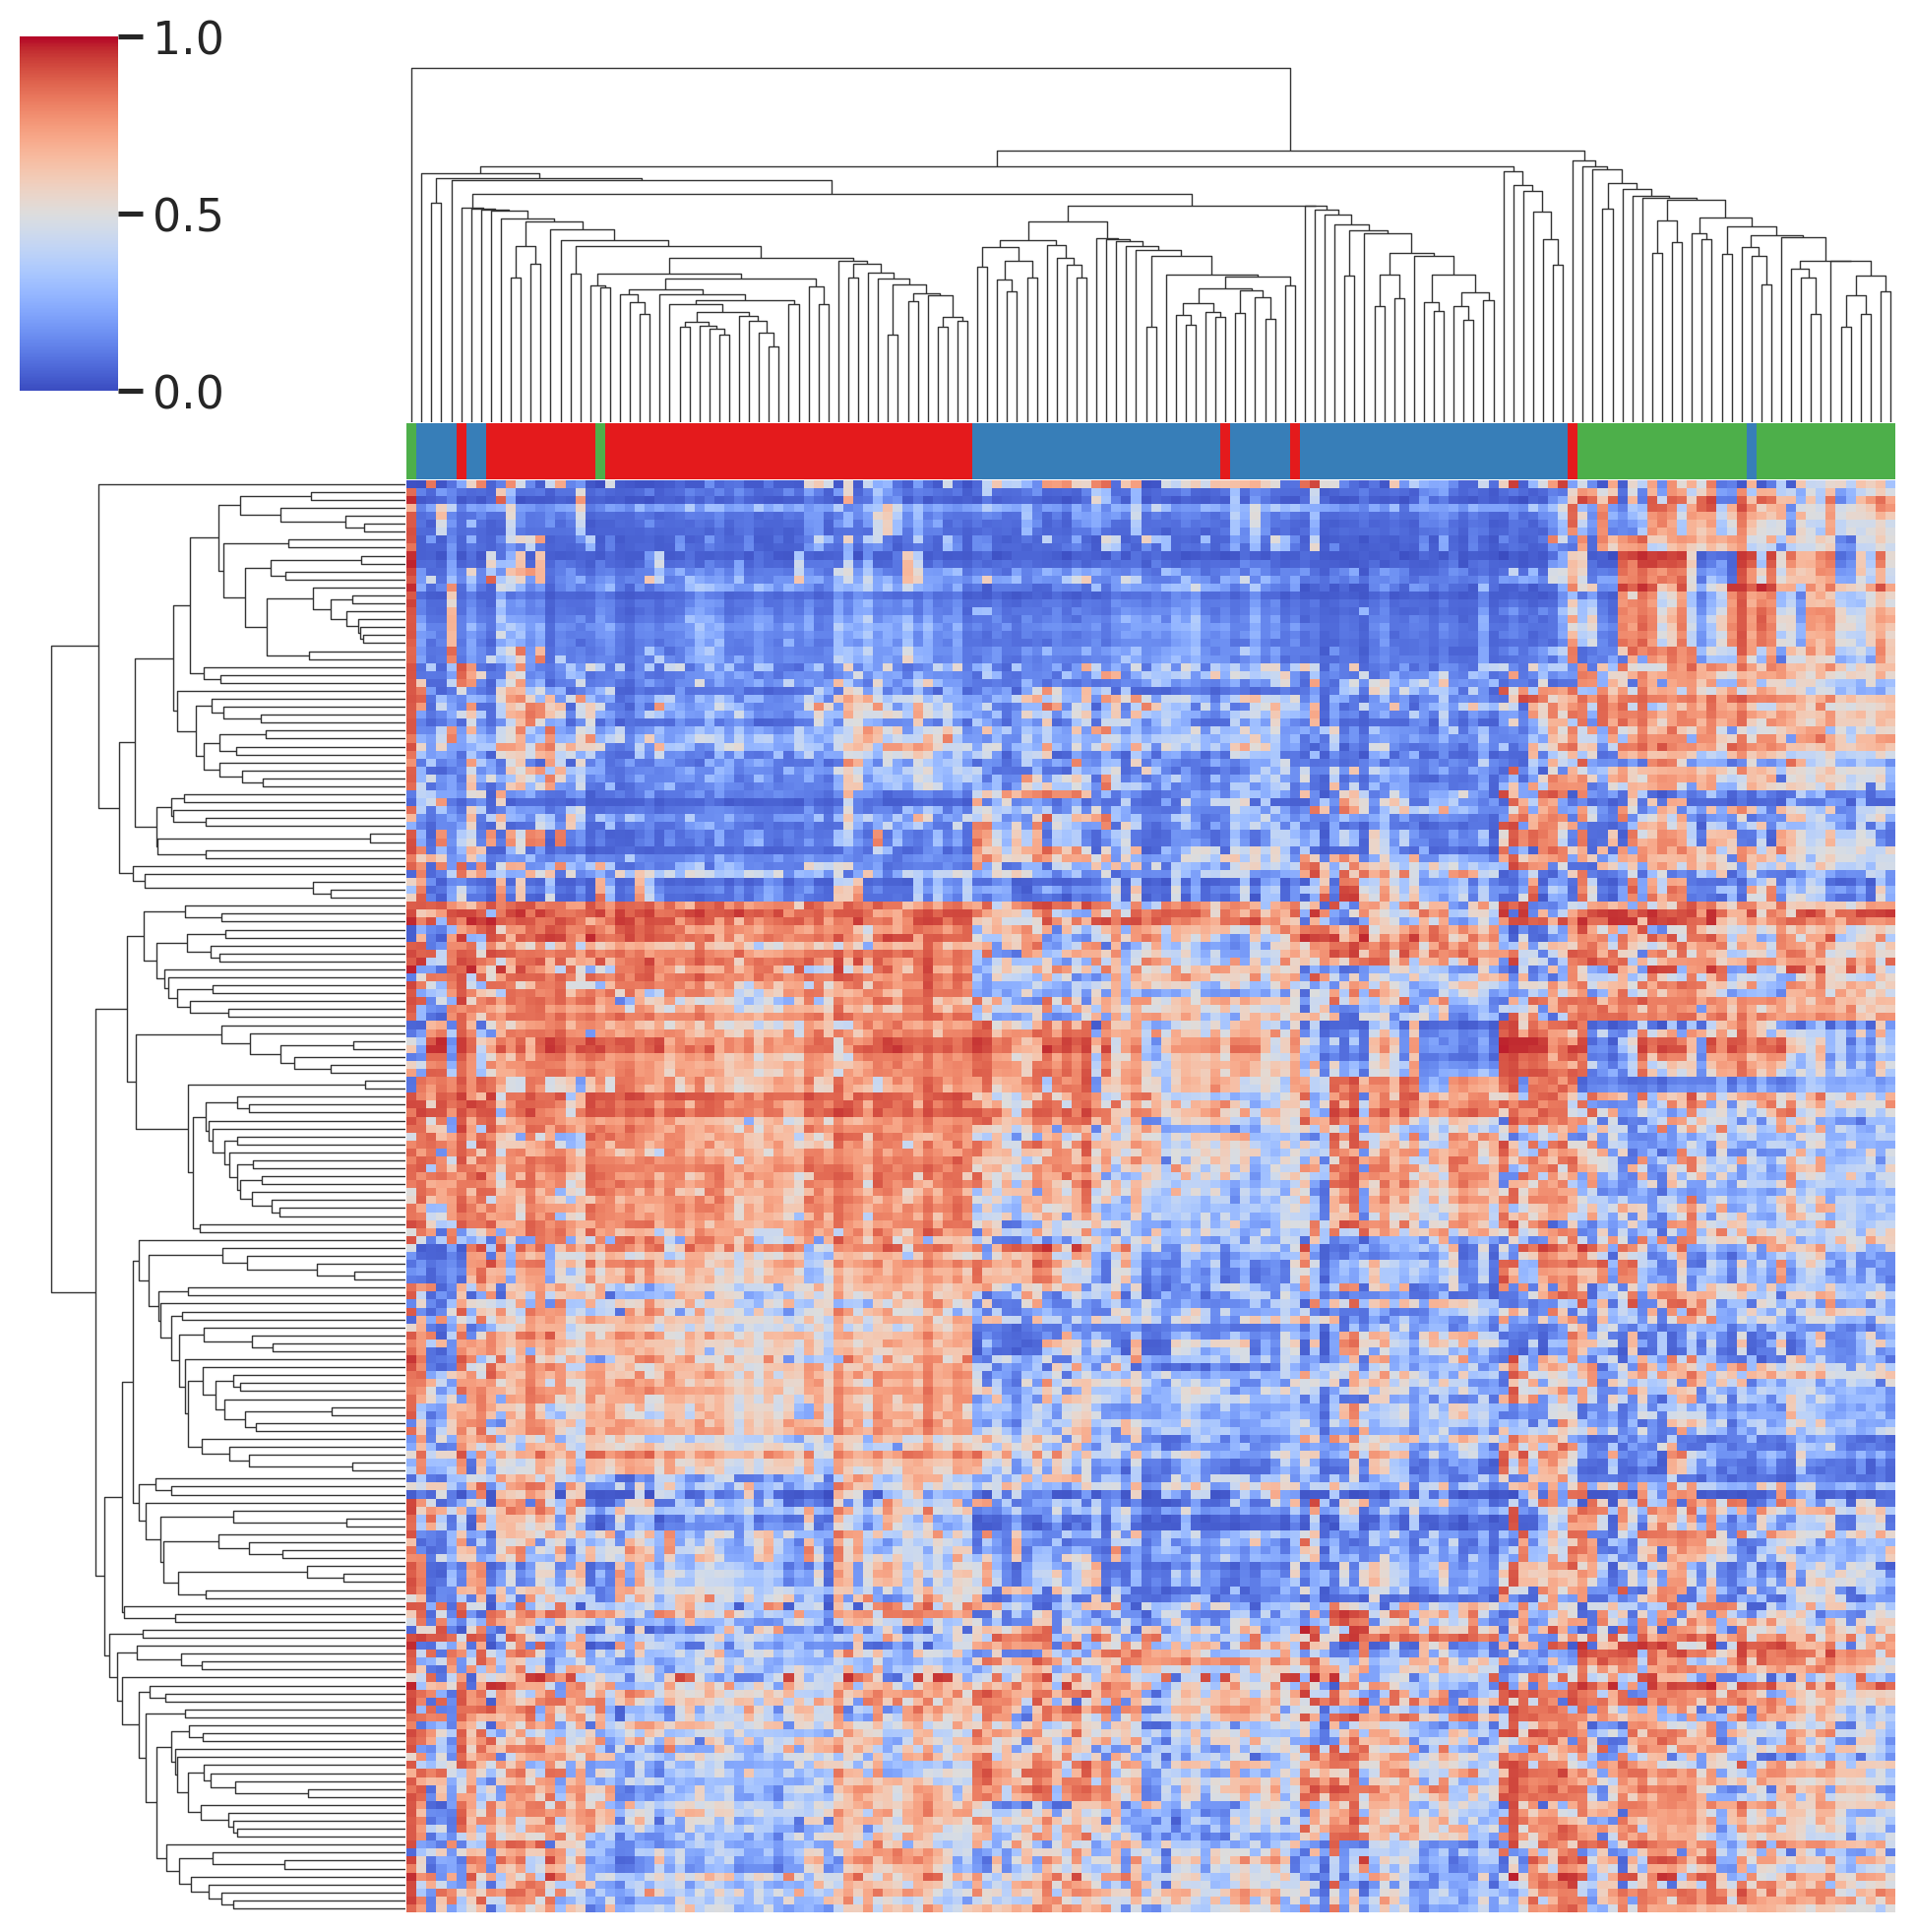

In [12]:
sns.clustermap(df_h_hv.values, 
               col_colors=pd.Series(clsts_order).astype(str).map(palette).values,
               row_linkage=rl_h, 
               col_linkage=cl_h, 
               yticklabels=False,
               xticklabels=False,
               cmap='coolwarm', 
               vmax=1, vmin=0,
              )

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


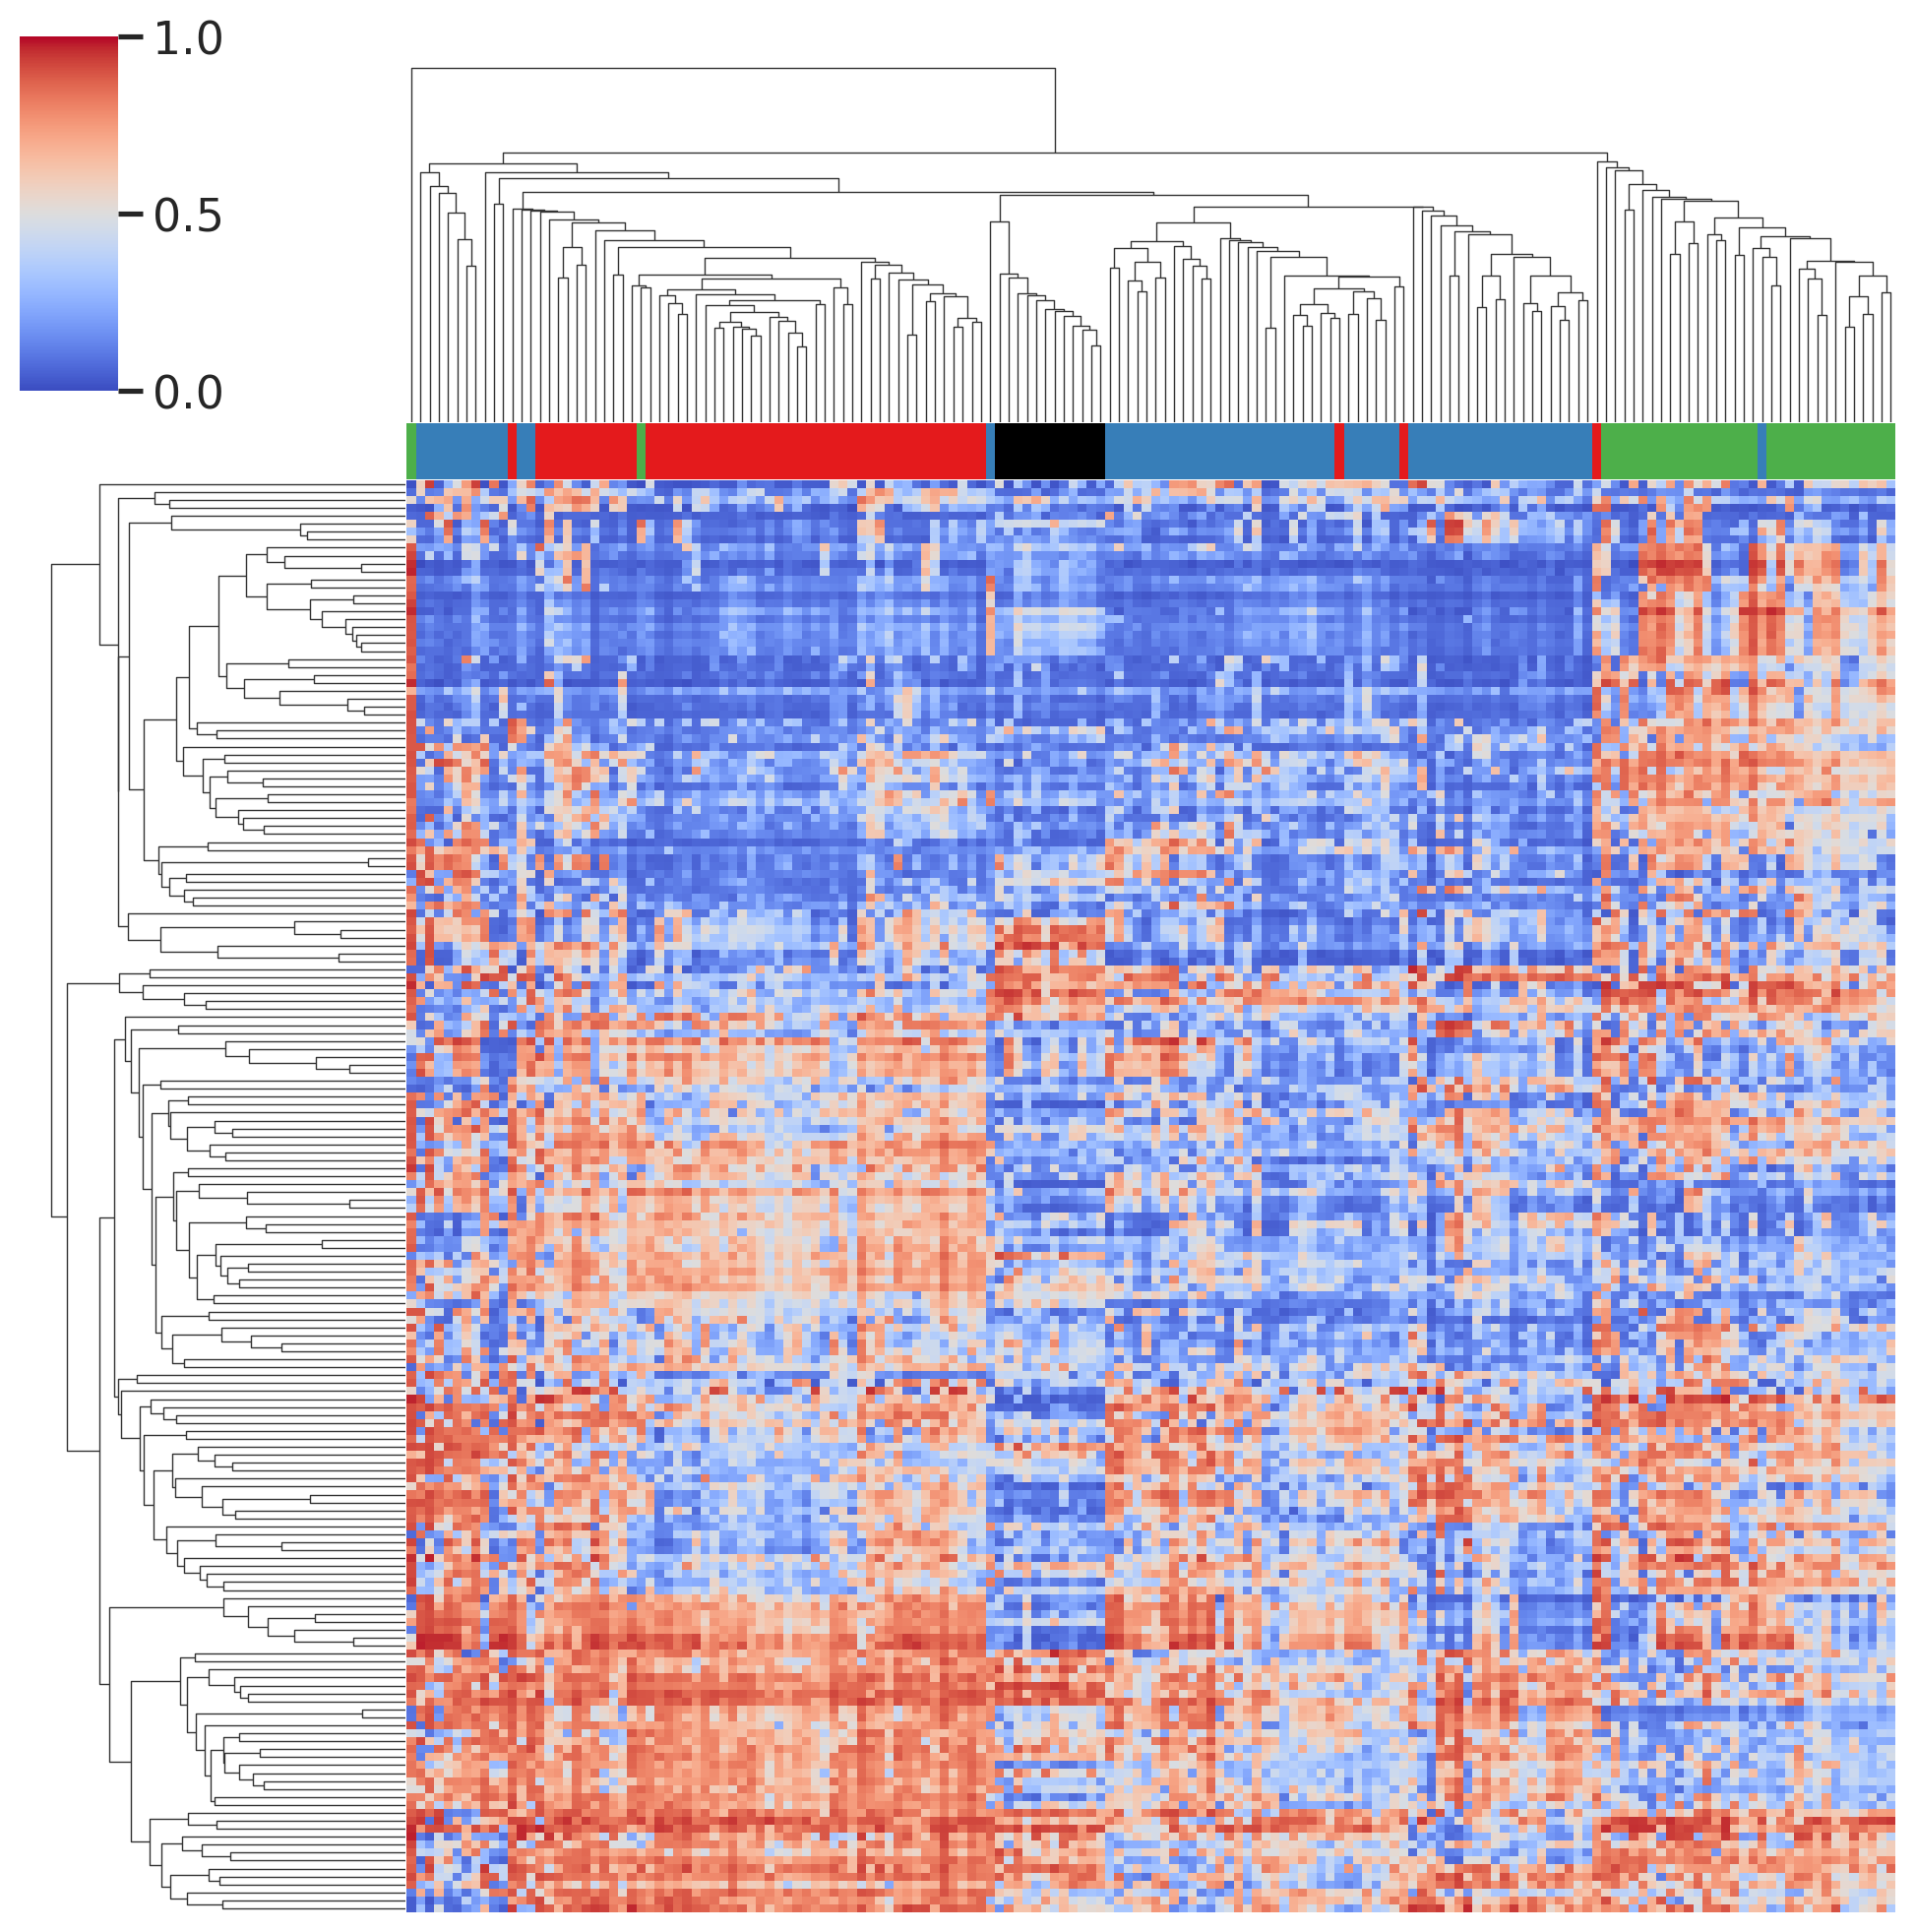

In [13]:
sns.clustermap(np.hstack([df_h_hv.values, df_m_hv.values]), 
               col_colors=pd.Series(clsts_order).astype(str).map(palette).tolist()+['black']*df_m_hv.shape[1],
               yticklabels=False,
               xticklabels=False,
               cmap='coolwarm', 
               vmax=1, vmin=0,
              )

# try more parameters

In [14]:
th = 0.2
cond_h = sites_std_h > th
print(cond_h.sum())

th = 0.02
cond_m = sites_std_m > th
print(cond_m.sum())

cond = np.logical_and(cond_h, cond_m)
print(cond.sum())

df_h_hv = df_h[cond]
df_m_hv = df_m[cond]
print(df_h_hv.shape, df_m_hv.shape)

263
1707
229
(229, 150) (229, 12)


In [15]:
rl_h = sch.linkage(df_h_hv.values,   method='average')
rl_m = sch.linkage(df_m_hv.values,   method='average')

cl_h = sch.linkage(df_h_hv.values.T, method='average')
cl_m = sch.linkage(df_m_hv.values.T, method='average')

rord_h = np.array(sch.dendrogram(rl_h, no_plot=True)['leaves'])
rord_m = np.array(sch.dendrogram(rl_m, no_plot=True)['leaves'])
cord_m = np.array(sch.dendrogram(cl_m, no_plot=True)['leaves'])

In [16]:
# sns.clustermap(df_h_hv.values, 
#                col_colors=pd.Series(clsts_order).astype(str).map(palette).values,
#                row_linkage=rl_h, 
#                col_linkage=cl_h, 
#                yticklabels=False,
#                xticklabels=False,
#                cmap='coolwarm', 
#                vmax=1, vmin=0,
#               )

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


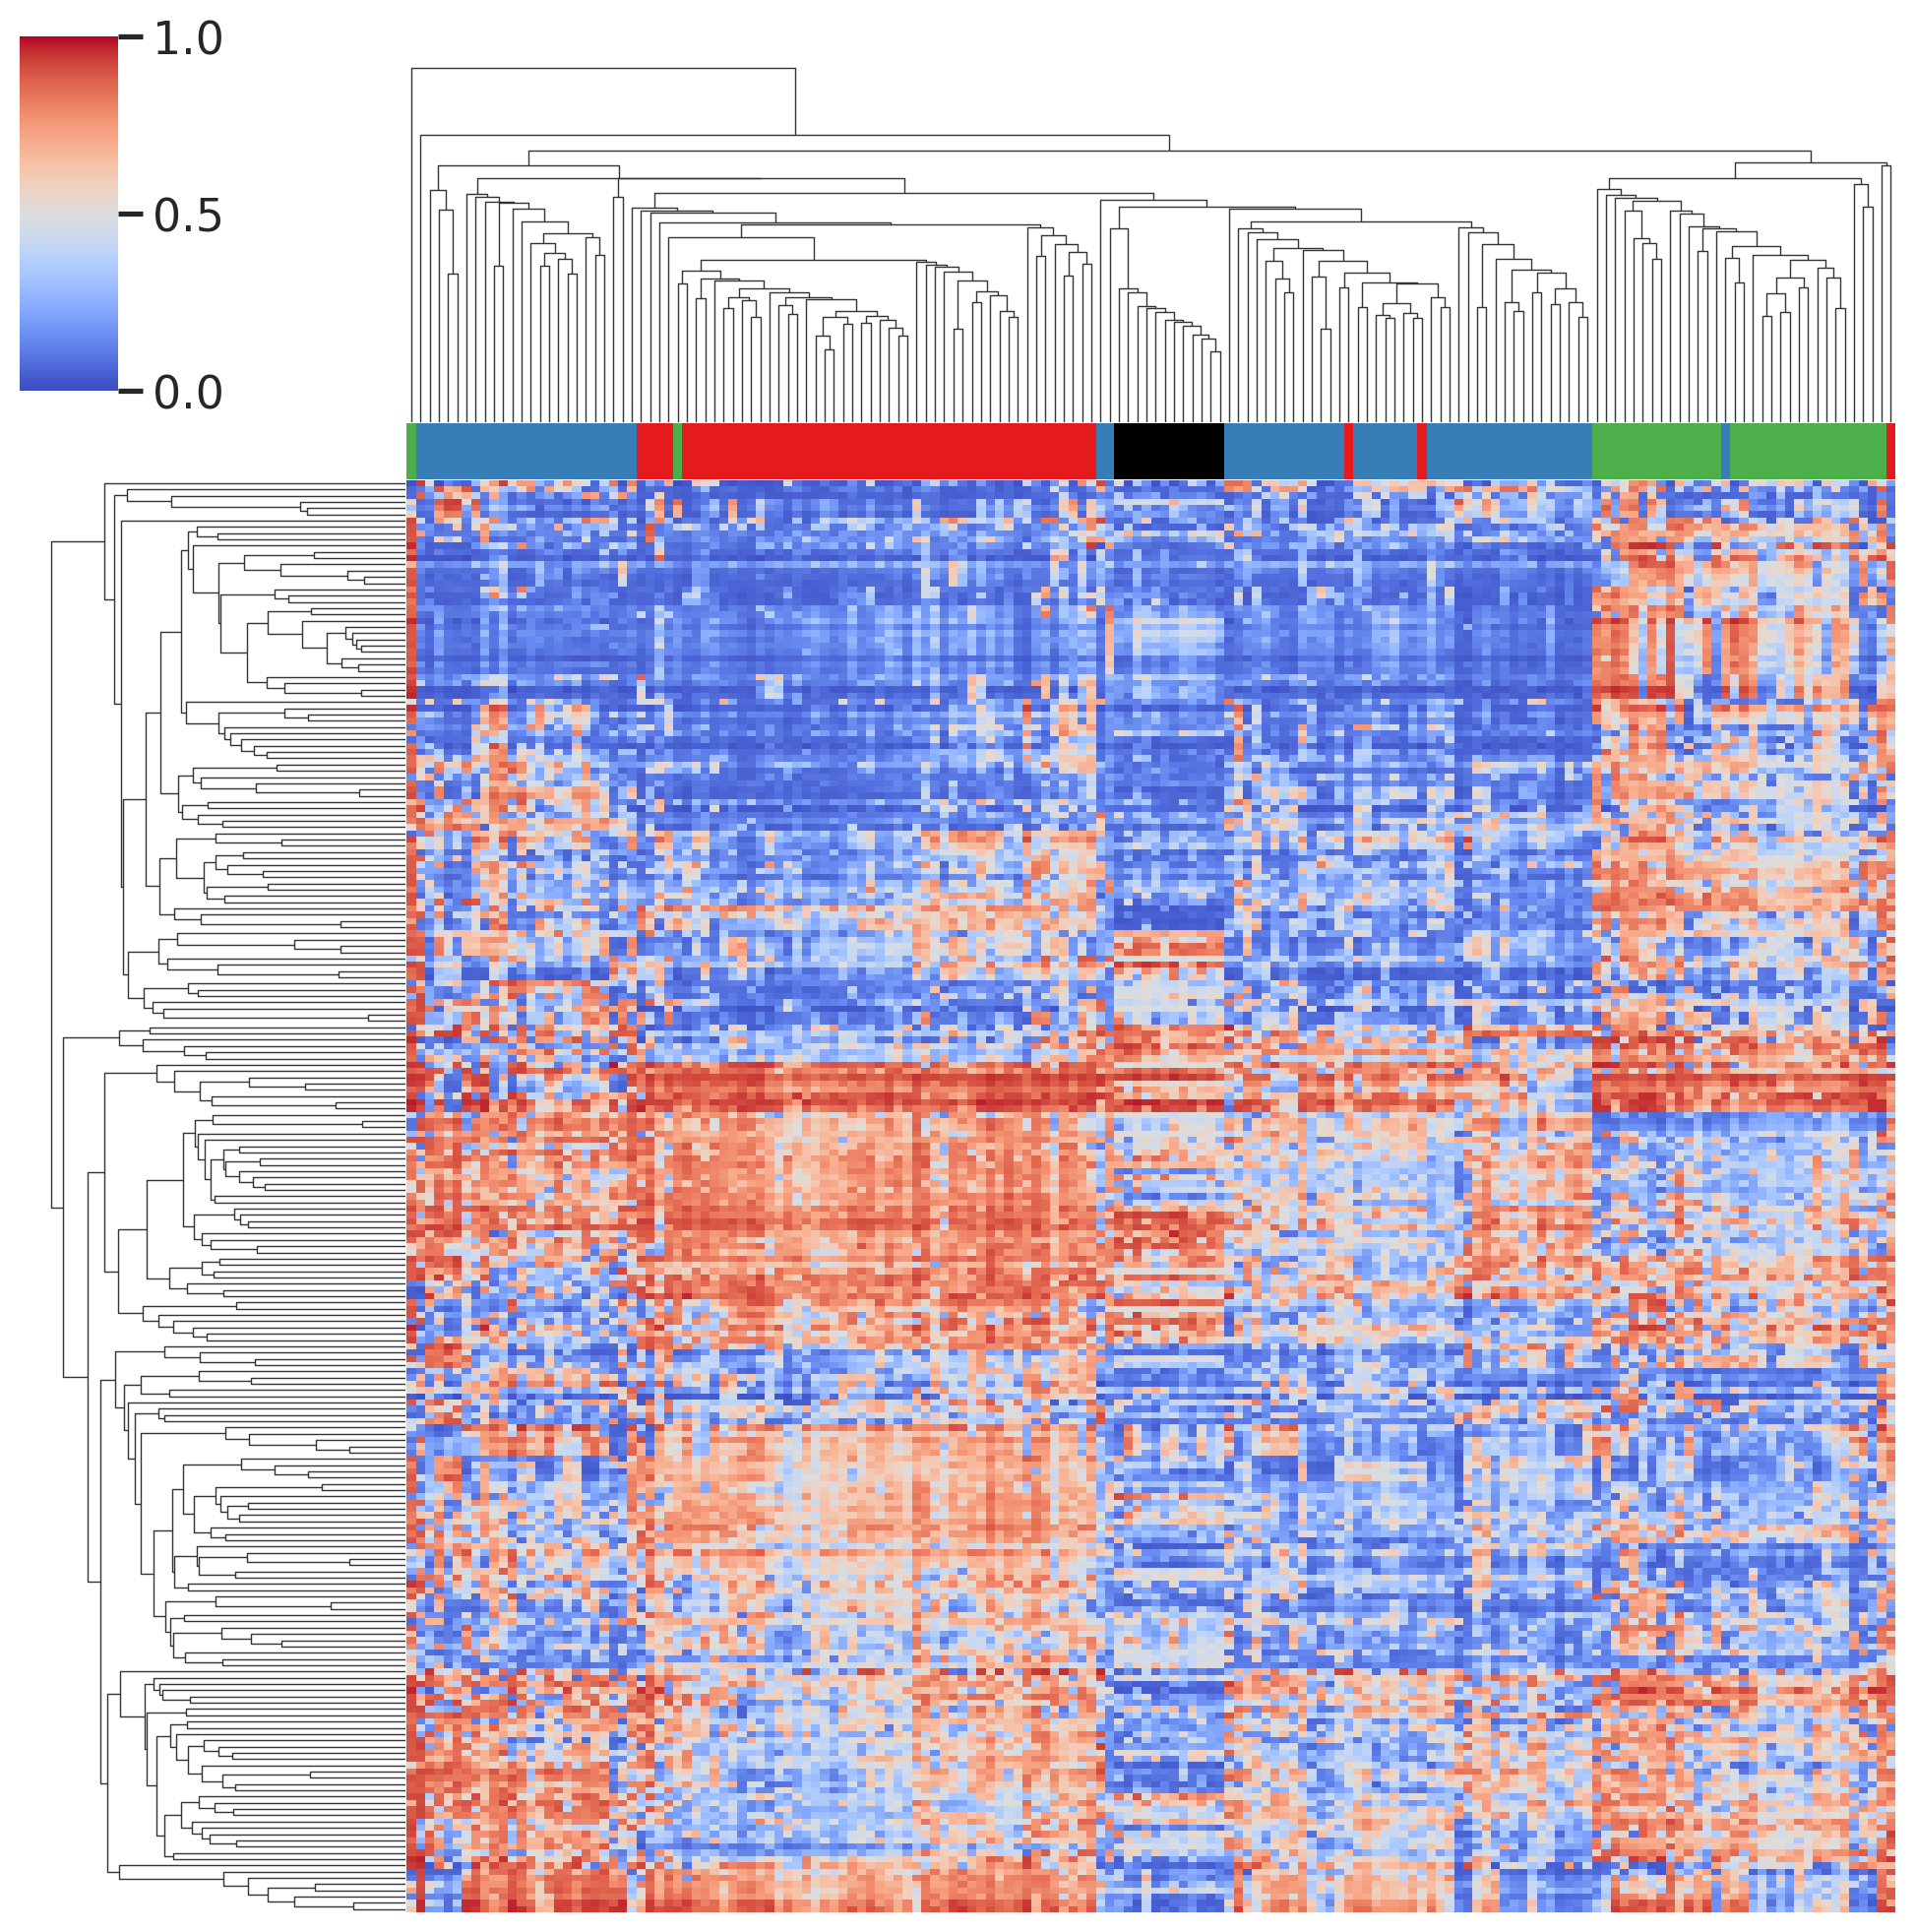

In [17]:
sns.clustermap(np.hstack([df_h_hv.values, df_m_hv.values]), 
               col_colors=pd.Series(clsts_order).astype(str).map(palette).tolist()+['black']*df_m_hv.shape[1],
               yticklabels=False,
               xticklabels=False,
               cmap='coolwarm', 
               vmax=1, vmin=0,
              )

In [18]:
# with sns.axes_style('white'):
#     # fig, axs = plt.subplots(1,2,figsize=(2*6,1*12), sharey=False)
#     fig = plt.figure(figsize=(2*6,1*12))
#     mosaic = 'AAAB'
#     ax_dict = fig.subplot_mosaic(mosaic)
#     ax = ax_dict['A']
#     # ax = axs[0]
#     sns.heatmap(
#         df_h_hv.values[rord_h], #[:,cord_h],
#         yticklabels=100,
#         cmap='coolwarm', 
#         cbar_kws=dict(shrink=0.3),
#         cbar=False,
#         vmax=1, vmin=0, 
#         ax=ax)
#     ax.set_title('Illu. 450k array - human\n(Johann et al. 2016)')
#     ax.set_ylabel(f'{len(rord_h)} sites')

#     ax = ax_dict['B']
#     # ax = axs[1]
#     sns.heatmap(
#         df_m_hv.values[rord_h][:,cord_m],
#         yticklabels=100,
#         cmap='coolwarm', 
#         cbar_kws=dict(shrink=0.3),
#         vmax=1, vmin=0, 
#         ax=ax)
#     ax.set_title('Mammal 320k array - mouse\n(Vitte et al. 2017)')
#     ax.set_ylabel(f'The same {len(rord_h)} orthologous sites')
#     fig.subplots_adjust(wspace=0.4)

In [19]:
# with sns.axes_style('white'):
#     # fig, axs = plt.subplots(1,2,figsize=(2*6,1*12), sharey=False)
#     fig = plt.figure(figsize=(2*6,1*12))
#     mosaic = 'AAAB'
#     ax_dict = fig.subplot_mosaic(mosaic)
#     ax = ax_dict['A']
#     # ax = axs[0]
#     sns.heatmap(
#         df_h_hv.values[rord_m], #[:,cord_h],
#         yticklabels=100,
#         cmap='coolwarm', 
#         cbar_kws=dict(shrink=0.3),
#         cbar=False,
#         vmax=1, vmin=0, 
#         ax=ax)
#     ax.set_title('Illu. 450k array - human\n(Johann et al. 2016)')
#     ax.set_ylabel(f'{len(rord_m)} sites')

#     ax = ax_dict['B']
#     # ax = axs[1]
#     sns.heatmap(
#         df_m_hv.values[rord_m][:,cord_m],
#         yticklabels=100,
#         cmap='coolwarm', 
#         cbar_kws=dict(shrink=0.3),
#         vmax=1, vmin=0, 
#         ax=ax)
#     ax.set_title('Mammal 320k array - mouse\n(Vitte et al. 2017)')
#     ax.set_ylabel(f'The same {len(rord_h)} orthologous sites')
#     fig.subplots_adjust(wspace=0.4)